Outlier :- a statistical observation that is markedly different in value from the others of the sample

Outlier detection is the identification of dataset elements that vary significantly from the majority

There are three basic approaches to outlier detection.
1. Unsupervised methods don’t require any information about the properties of neither the outliers, nor the normal elements (known as inliers).
2. Semi-supervised methods need to be trained on a set of normal elements, and are able to detect those that differ significantly.
3. Supervised methods require a labeled dataset with both inliers and outliers, making them similar to classification algorithms, specifically suited for imbalanced classes.

Alibi Detect
Alibi Detect is an open source Python library for outlier, adversarial and drift detection, that includes a variety of powerful algorithms and techniques. It also supports various data types, such as tabular, time series and image.



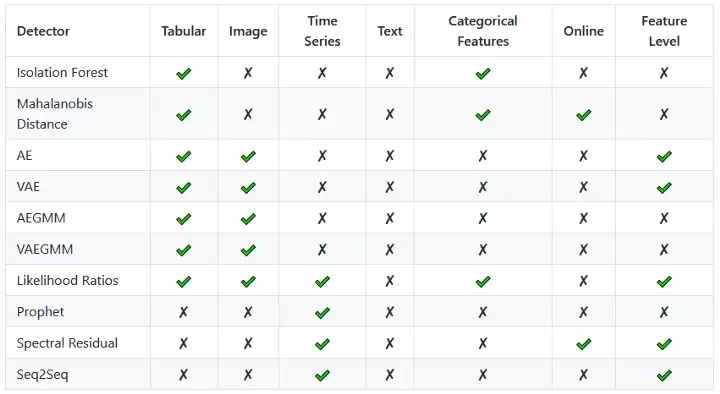

Suggested use for each algorithm included in the Alibi Detect library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os
import shutil
from collections import Counter
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D,Dense, Layer, Reshape, InputLayer, Flatten, Input, MaxPooling2D
from alibi_detect.od import OutlierAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

2023-03-02 08:38:57.533252: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 08:38:58.404633: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-02 08:38:58.404677: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-02 08:39:00.915527: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

The MVTec AD Dataset

The MVTec AD dataset contains thousands of high-resolution images, and is suitable for testing and benchmarking image outlier models, with a focus on industrial manufacturing quality control. 
The dataset is comprised of 15 categories of images

In [2]:
def img_to_np(path, resize = True):  
    img_array = []
    fpaths = glob.glob(path, recursive=True)
    for fname in fpaths:
        img = Image.open(fname).convert("RGB")
        if(resize): img = img.resize((64,64))
        img_array.append(np.asarray(img))
    images = np.array(img_array)
    return images

Outlier Detection with Alibi Detect

We are now going to create an image outlier detection model, based on the autoencoder algorithm of the Alibi Detect library. The model will be trained and tested on the capsule images of the MVTec AD dataset, following the semi-supervised approach, as the training set will be comprised of normal (inlier) images only.

In [3]:
path_train = "capsule/train/good/*.png"

In [4]:
path_test = "capsule/test/**/*.*"

In [5]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [6]:
train = img_to_np(path_train)

In [7]:
test = img_to_np(path_test)

In [8]:
train = train.astype('float32') / 255.
test = test.astype('float32') / 255.

In [9]:
encoding_dim = 1024
dense_dim = [8, 8, 128]

Autoencoders
Autoencoders are a type of artificial neural network, comprised of an encoder and a decoder. The input is transformed to a latent space representation by the encoder, while the decoder receives that representation and outputs a reconstruction of the input data¹. There are various applications for autoencoders, such as dimensionality reduction and image denoising, but we are going to focus on image outlier detection

In [10]:
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

In [11]:
decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(np.prod(dense_dim)),
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

We then instantiate the OutlierAE detector class, which takes the encoder and decoder layers as input, and train the model on the appropriate set. We also need to define a threshold value, above which the element is flagged as an outlier. We calculate the threshold with the infer_threshold function, which takes the percentage of inlier values as a parameter.

In [12]:
od = OutlierAE( threshold = 0.001,
                encoder_net=encoder_net,
                decoder_net=decoder_net)

In [13]:
adam = tf.keras.optimizers.Adam(lr=1e-4)

In [14]:
od.fit(train, epochs=100, verbose=True,
       optimizer = adam)

3/3 [=] - 6s 2s/step - loss_ma: 4.0828e-04


In [15]:
od.infer_threshold(test, threshold_perc=95)

we detect the outliers of the test set, by using the predict function, which returns a dictionary with predictions for each element. The instance_score key contains the instance level score, with the element being flagged as an outlier in case it is above the threshold. Furthermore, the feature_score key contains the scores of each individual pixel of the image.

In [16]:
preds = od.predict(test, outlier_type='instance',
            return_instance_score=True,
            return_feature_score=True)

In [17]:
preds

{'data': {'instance_score': array([0.00042601, 0.00030135, 0.00045163, 0.00085529, 0.00039926,
         0.00020728, 0.00037235, 0.00019618, 0.00070821, 0.00042218,
         0.00048269, 0.00036746, 0.00027471, 0.00083375, 0.00051122,
         0.00074492, 0.00047694, 0.00037467, 0.00020174, 0.00050956,
         0.00023592, 0.00316776, 0.00129439, 0.00030381, 0.00043624,
         0.00018258, 0.0003982 , 0.00021472, 0.00034237, 0.0002242 ,
         0.00047323, 0.00028317, 0.00040511, 0.00015178, 0.0002227 ,
         0.0004376 , 0.00037593, 0.00039232, 0.00019438, 0.00028758,
         0.00021346, 0.00029775, 0.00078143, 0.00030233, 0.00046716,
         0.00033207, 0.00031733, 0.00010782, 0.00026598, 0.00015818,
         0.0003385 , 0.00043871, 0.0001156 , 0.00092254, 0.00054695,
         0.00025861, 0.00048279, 0.00012277, 0.00028772, 0.00020104,
         0.00026994, 0.00018481, 0.00039604, 0.00018692, 0.0002635 ,
         0.00023199, 0.00034905, 0.00042363, 0.0003289 , 0.00010554,
        

In [18]:
for i, fpath in enumerate(glob.glob(path_test)):
    if(preds['data']['is_outlier'][i] == 1):
        source = fpath
        shutil.copy(source, 'olier/')

PermissionError: [Errno 13] Permission denied: 'olier/001.png'

In [23]:
filenames = [os.path.basename(x) for x in glob.glob(path_test, recursive=True)]

In [24]:
filenames

['013.png',
 '009.png',
 '016.png',
 '020.png',
 '002.png',
 '005.png',
 '017.png',
 '000.png',
 '012.png',
 '015.png',
 '011.png',
 '018.png',
 '014.png',
 '004.png',
 '008.png',
 '021.png',
 '006.png',
 '019.png',
 '007.png',
 '003.png',
 '022.png',
 '001.png',
 '010.png',
 '013.png',
 '009.png',
 '016.png',
 '020.png',
 '002.png',
 '005.png',
 '017.png',
 '000.png',
 '012.png',
 '015.png',
 '011.png',
 '018.png',
 '014.png',
 '004.png',
 '008.png',
 '021.png',
 '006.png',
 '019.png',
 '007.png',
 '003.png',
 '022.png',
 '001.png',
 '010.png',
 '013.png',
 '009.png',
 '016.png',
 '020.png',
 '002.png',
 '005.png',
 '017.png',
 '000.png',
 '012.png',
 '015.png',
 '011.png',
 '018.png',
 '014.png',
 '004.png',
 '008.png',
 '006.png',
 '019.png',
 '007.png',
 '003.png',
 '001.png',
 '010.png',
 '013.png',
 '009.png',
 '016.png',
 '020.png',
 '002.png',
 '005.png',
 '017.png',
 '000.png',
 '012.png',
 '015.png',
 '011.png',
 '018.png',
 '014.png',
 '004.png',
 '008.png',
 '021.png',
 '00

In [25]:
dict1 = {'Filename': filenames,
     'instance_score': preds['data']['instance_score'],
     'is_outlier': preds['data']['is_outlier']}

In [26]:
dict1

{'Filename': ['013.png',
  '009.png',
  '016.png',
  '020.png',
  '002.png',
  '005.png',
  '017.png',
  '000.png',
  '012.png',
  '015.png',
  '011.png',
  '018.png',
  '014.png',
  '004.png',
  '008.png',
  '021.png',
  '006.png',
  '019.png',
  '007.png',
  '003.png',
  '022.png',
  '001.png',
  '010.png',
  '013.png',
  '009.png',
  '016.png',
  '020.png',
  '002.png',
  '005.png',
  '017.png',
  '000.png',
  '012.png',
  '015.png',
  '011.png',
  '018.png',
  '014.png',
  '004.png',
  '008.png',
  '021.png',
  '006.png',
  '019.png',
  '007.png',
  '003.png',
  '022.png',
  '001.png',
  '010.png',
  '013.png',
  '009.png',
  '016.png',
  '020.png',
  '002.png',
  '005.png',
  '017.png',
  '000.png',
  '012.png',
  '015.png',
  '011.png',
  '018.png',
  '014.png',
  '004.png',
  '008.png',
  '006.png',
  '019.png',
  '007.png',
  '003.png',
  '001.png',
  '010.png',
  '013.png',
  '009.png',
  '016.png',
  '020.png',
  '002.png',
  '005.png',
  '017.png',
  '000.png',
  '012.png',


In [27]:
df = pd.DataFrame(dict1)
df_outliers = df[df['is_outlier'] == 1]

In [28]:
print(df_outliers)

    Filename  instance_score  is_outlier
21   001.png        0.003168           1
113  009.png        0.002142           1
120  015.png        0.002789           1
121  011.png        0.002063           1
123  014.png        0.003861           1
128  007.png        0.004558           1
130  001.png        0.003732           1


In [29]:
recon = od.ae(test).numpy()

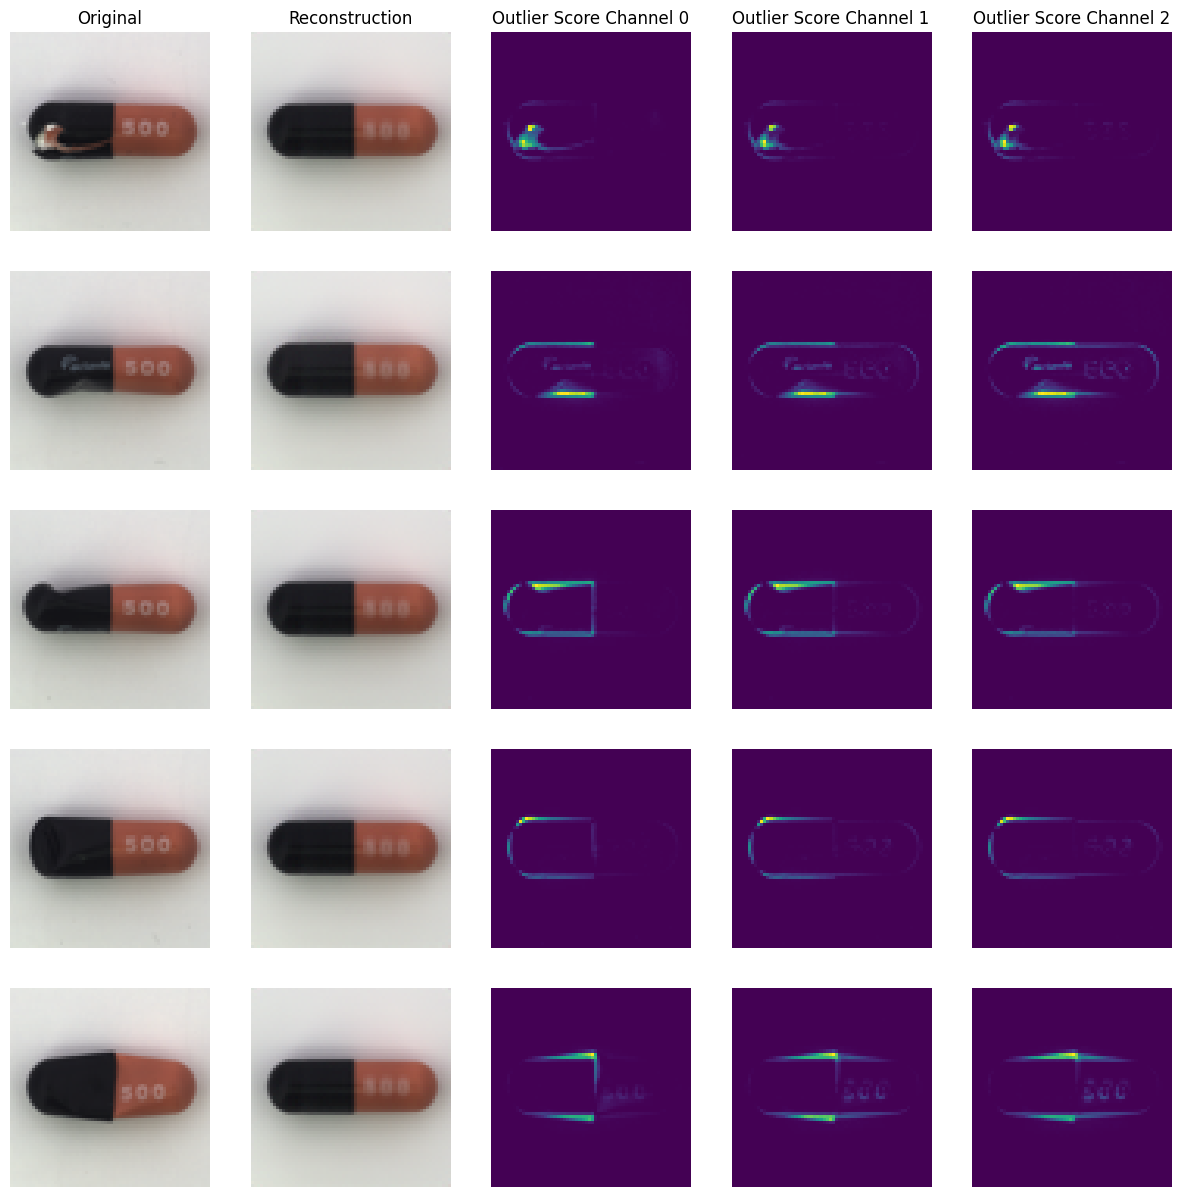

In [30]:
plot_feature_outlier_image(preds, test, 
                           X_recon=recon,  
                           max_instances=5,
                           outliers_only=True,
                           figsize=(15,15))